In [53]:
import os
from PIL import Image, ImageEnhance
import random

# 資料夾路徑
data_folder = "ETT_v3/Fold1" #手動變更路徑

# 定義訓練集、驗證集和測試集資料夾路徑
train_folder = os.path.join(data_folder, "train")
val_folder = os.path.join(data_folder, "val")
test_folder = os.path.join(data_folder, "test")

# 定義訓練目標遮罩、驗證目標遮罩和測試目標遮罩資料夾路徑
train_annot_folder = os.path.join(data_folder, "trainannot")
val_annot_folder = os.path.join(data_folder, "valannot")
test_annot_folder = os.path.join(data_folder, "testannot")

# 確保輸出目錄存在，如果不存在則創建它們
os.makedirs(os.path.join(data_folder, "train_preprocessed"), exist_ok=True)
os.makedirs(os.path.join(data_folder, "trainannot_preprocessed"), exist_ok=True)
os.makedirs(os.path.join(data_folder, "val_preprocessed"), exist_ok=True)
os.makedirs(os.path.join(data_folder, "valannot_preprocessed"), exist_ok=True)
os.makedirs(os.path.join(data_folder, "test_preprocessed"), exist_ok=True)
os.makedirs(os.path.join(data_folder, "testannot_preprocessed"), exist_ok=True)


# 定義圖像預處理函數
def preprocess_image(image_path, target_size=(256, 256), grayscale=False):
    image = Image.open(image_path)
    if grayscale:
        image = image.convert("L")  # 將圖像轉換為灰階
    image = image.resize(target_size)
    return image

# 定義圖像增強函數
def enhance_image(image):
    # 隨機翻轉圖像
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # 隨機增強對比度
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    
    # 隨機旋轉圖像
    angle = random.randint(-30, 30)
    image = image.rotate(angle, resample=Image.BICUBIC, expand=True)
    
    # 隨機水平和垂直位移
    width, height = image.size
    max_shift = min(width, height) // 10
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    image = image.transform(image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y), resample=Image.BICUBIC)
    
    return image

# 預處理資料集
def preprocess_dataset(input_folder, output_folder, enhance=False):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            # 圖像預處理
            image_path = os.path.join(input_folder, filename)
            preprocessed_image = preprocess_image(image_path, grayscale=True)
            preprocessed_image.save(os.path.join(output_folder, filename))

            # 如果需要增強，且目前處理的是 train 資料夾
            if enhance and input_folder == train_folder:
                # 圖像增強
                enhanced_image = enhance_image(preprocessed_image)
                enhanced_filename = filename.split(".")[0] + "_enhanced.jpg"
                enhanced_image.save(os.path.join(output_folder, enhanced_filename))
                # 保存增強後的圖像

                # 執行一次增強後，再次進行一次增強
                enhanced_image_2 = enhance_image(preprocessed_image)
                enhanced_filename_2 = filename.split(".")[0] + "_enhanced_2.jpg"
                enhanced_image_2.save(os.path.join(output_folder, enhanced_filename_2))

        if filename.endswith(".png"):
            # 圖像預處理
            image_path = os.path.join(input_folder, filename)
            preprocessed_image = preprocess_image(image_path, grayscale=True)
            preprocessed_image.save(os.path.join(output_folder, filename))

            # 如果需要增強，且目前處理的是 trainannot 資料夾
            #if enhance and input_folder == train_annot_folder:
                # 圖像增強
                #preprocessed_image = enhance_image(preprocessed_image)
                #preprocessed_image.save(os.path.join(output_folder, filename))

# 在 train 資料集上進行圖像預處理和增強
preprocess_dataset(train_folder, os.path.join(data_folder, "train_preprocessed"), enhance=True)
preprocess_dataset(train_annot_folder, os.path.join(data_folder, "trainannot_preprocessed"), enhance=True)

# 在 val 資料集上進行圖像預處理
preprocess_dataset(val_folder, os.path.join(data_folder, "val_preprocessed"))
preprocess_dataset(val_annot_folder, os.path.join(data_folder, "valannot_preprocessed"))

# 在 test 資料集上進行圖像預處理
preprocess_dataset(test_folder, os.path.join(data_folder, "test_preprocessed"))
preprocess_dataset(test_annot_folder, os.path.join(data_folder, "testannot_preprocessed"))

print("資料準備完成")






資料準備完成


In [62]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
   
  
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

print("Model完成")

Model完成


In [59]:
# 模型加入L2
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.regularizers import l2

def unet2(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.1))(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

print("Model2完成")


Model2完成


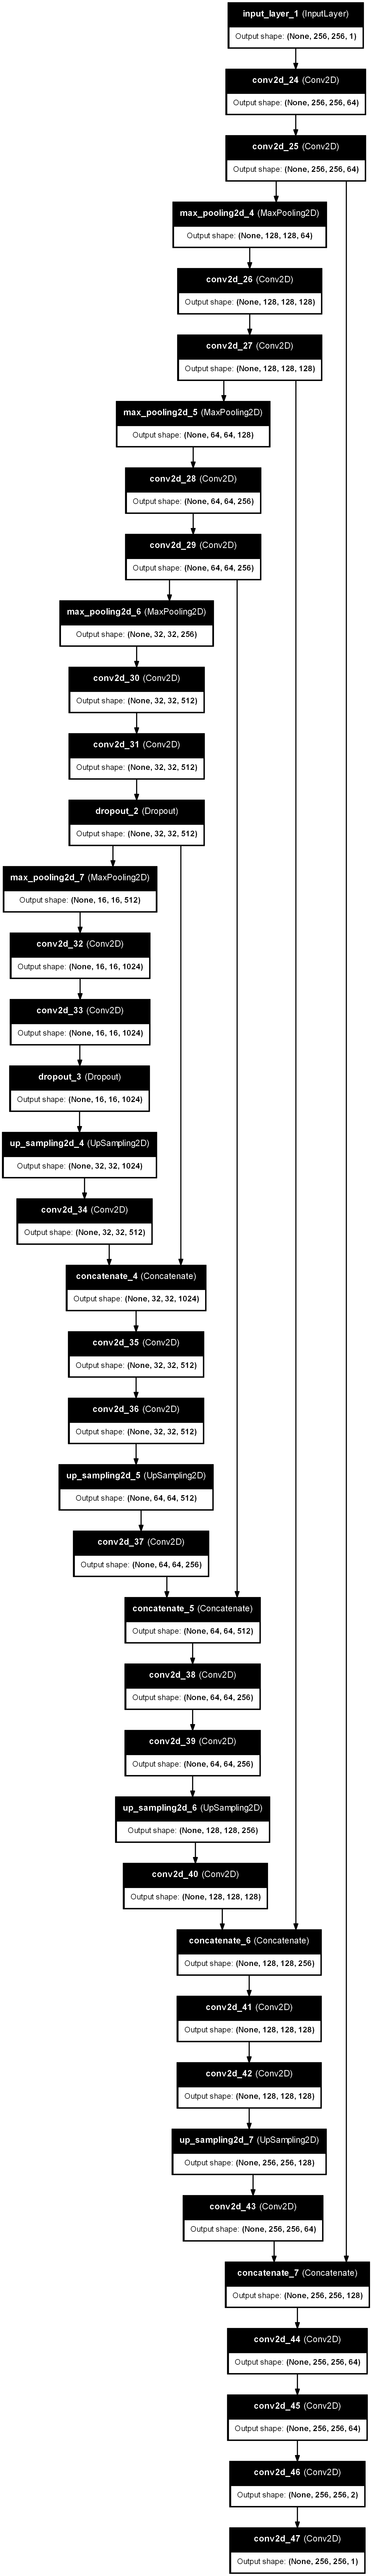

In [4]:
import tensorflow.keras.utils as ku
import matplotlib.pyplot as plt
model=unet()

ku.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)




Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3527 - loss: -19.4307 
Epoch 1: loss improved from inf to -2992.95435, saving model to 22unet_fold1.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 398s 23s/step - accuracy: 0.3399 - loss: -184.6265 - val_accuracy: 9.2506e-05 - val_loss: -24138.6426
Epoch 2/15

Epoch 2: loss did not improve from -2992.95435
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 8.3760e-05 - loss: -114473328.0000
Epoch 3: loss improved from -2992.95435 to -764176256.00000, saving model to 22unet_fold1.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 388s 23s/step - accuracy: 8.3292e-05 - loss: -150567936.0000 - val_accuracy: 9.2506e-05 - val_loss: -7710060544.0000
Epoch 4/15

Epoch 4: loss did not improve from -764176256.00000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 -

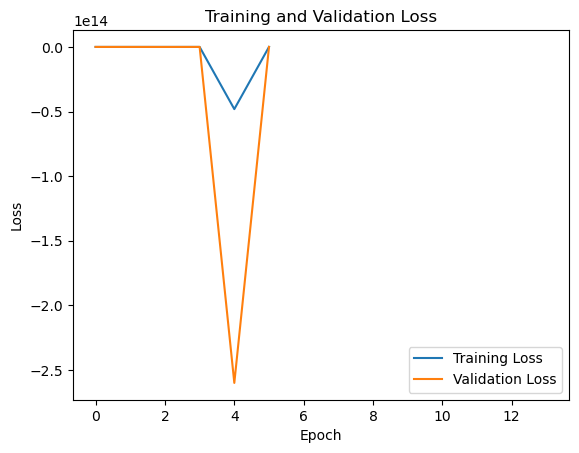

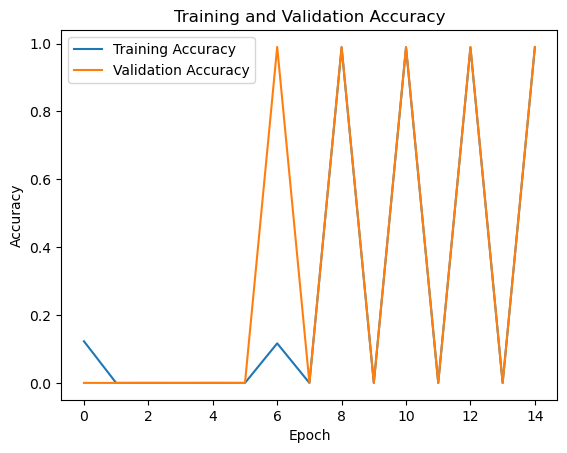

訓練完成


In [63]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Define a class for the image data generator
class ImageDataGenerator(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")  # Change to single channel
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")  # Load as grayscale
            x[j] = np.expand_dims(img, 2)  # Expand dimensions to match input shape
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


# Define image size, batch size, etc.
img_size = (256, 256)
batch_size = 16

# Get paths of input and target images
train_folder = "ETT_v3/Fold1/train_preprocessed"
train_annot_folder = "ETT_v3/Fold1/trainannot_preprocessed"
val_folder = "ETT_v3/Fold1/val_preprocessed"
val_annot_folder = "ETT_v3/Fold1/valannot_preprocessed"

train_input_img_paths = sorted([os.path.join(train_folder, fname) for fname in os.listdir(train_folder) if fname.endswith(".jpg")])
train_target_img_paths = sorted([os.path.join(train_annot_folder, fname) for fname in os.listdir(train_annot_folder) if fname.endswith(".png") and not fname.startswith(".")])
val_input_img_paths = sorted([os.path.join(val_folder, fname) for fname in os.listdir(val_folder) if fname.endswith(".jpg")])
val_target_img_paths = sorted([os.path.join(val_annot_folder, fname) for fname in os.listdir(val_annot_folder) if fname.endswith(".png") and not fname.startswith(".")])

# Create data generators for training and validation
train_gen = ImageDataGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = ImageDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Define your model
model = unet()

# Train your model
model_checkpoint = ModelCheckpoint('22unet_fold1.keras', monitor='loss', verbose=1, save_best_only=True)
history = model.fit(train_gen, steps_per_epoch=len(train_gen), epochs=15, validation_data=val_gen, validation_steps=len(val_gen), callbacks=[model_checkpoint])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

print('訓練完成')


In [64]:
#用訓練好的模型測績效
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# 加載模型
model = load_model('22unet_fold1.keras')

def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# 加載訓練集
train_folder = "ETT_v3/Fold1/train_preprocessed"
train_annot_folder = "ETT_v3/Fold1/trainannot_preprocessed"
train_input_img_paths = sorted([os.path.join(train_folder, fname) for fname in os.listdir(train_folder) if fname.endswith(".jpg")])
train_target_img_paths = sorted([os.path.join(train_annot_folder, fname) for fname in os.listdir(train_annot_folder) if fname.endswith(".png") and not fname.startswith(".")])

train_gen = ImageDataGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)

# 預測訓練集數據
train_predictions = model.predict(train_gen, steps=len(train_gen), verbose=0)

# 計算訓練集 IOU
train_iou_scores = []
for i in range(len(train_gen)):
    batch_x, batch_y = train_gen[i]
    pred_masks = model.predict(batch_x)
    for true_mask, pred_mask in zip(batch_y, pred_masks):
        binary_pred_mask = (pred_mask > 0.5).astype(int)  # 將模型預測二值化
        iou = calculate_iou(true_mask, binary_pred_mask)  # 計算 IoU
        train_iou_scores.append(iou)

mean_train_iou = np.mean(train_iou_scores)
print("Train Mean IoU:", mean_train_iou)

# 加載測試集
test_folder = "ETT_v3/Fold1/test_preprocessed" 
test_annot_folder = "ETT_v3/Fold1/testannot_preprocessed"
test_input_img_paths = sorted([os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.endswith(".jpg")])
test_target_img_paths = sorted([os.path.join(test_annot_folder, fname) for fname in os.listdir(test_annot_folder) if fname.endswith(".png") and not fname.startswith(".")])

test_gen = ImageDataGenerator(batch_size, img_size, test_input_img_paths, test_target_img_paths)

# 預測測試集數據
predictions = model.predict(test_gen, steps=len(test_gen), verbose=0)

# 計算測試集 IOU
iou_scores = []
for true, pred in zip(test_gen, predictions):
    true_mask = true[1]  # 取出真實標籤
    binary_pred = (pred > 0.5).astype(int)  # 將模型預測二值化
    iou = calculate_iou(true_mask, binary_pred)  # 計算 IoU
    iou_scores.append(iou)

mean_iou = np.mean(iou_scores)
print("Test Mean IoU:", mean_iou)





1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Train Mean IoU: 0.011708662636489706
Test Mean IoU: 0.008930819409475852


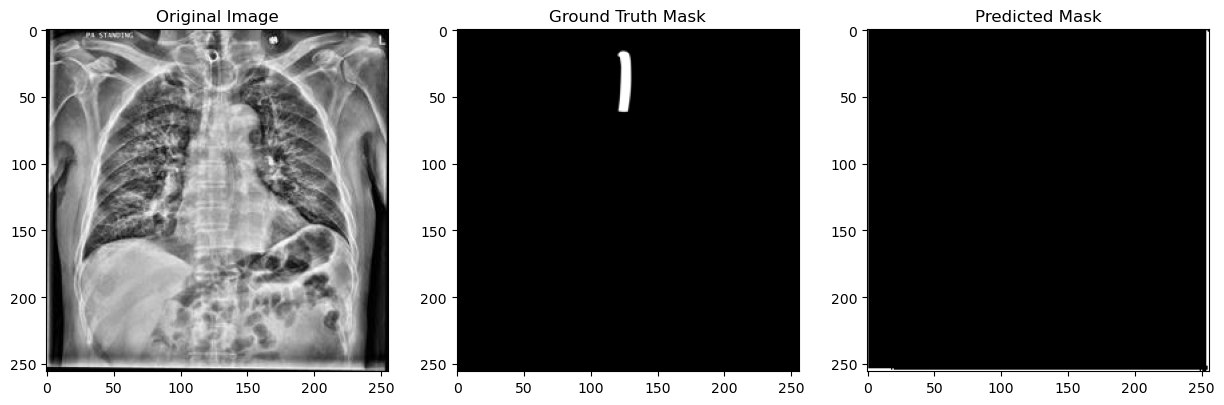

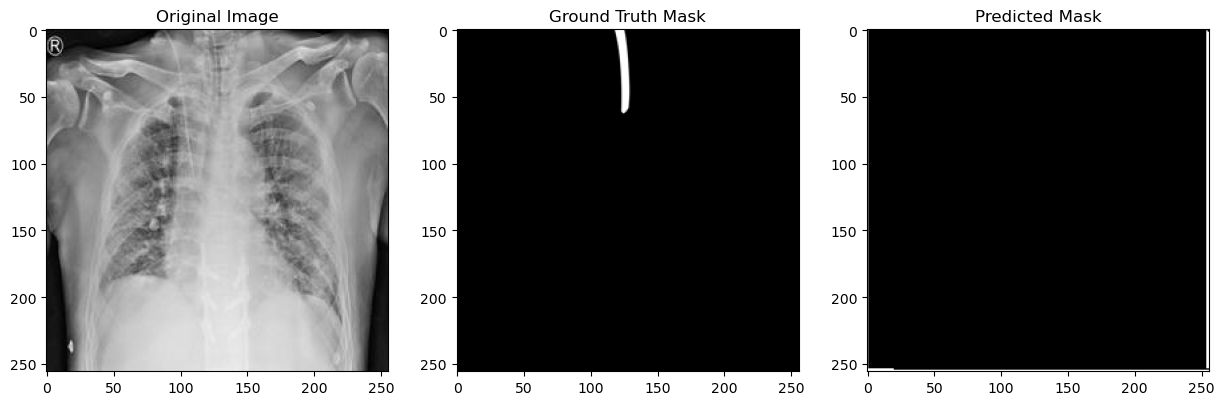

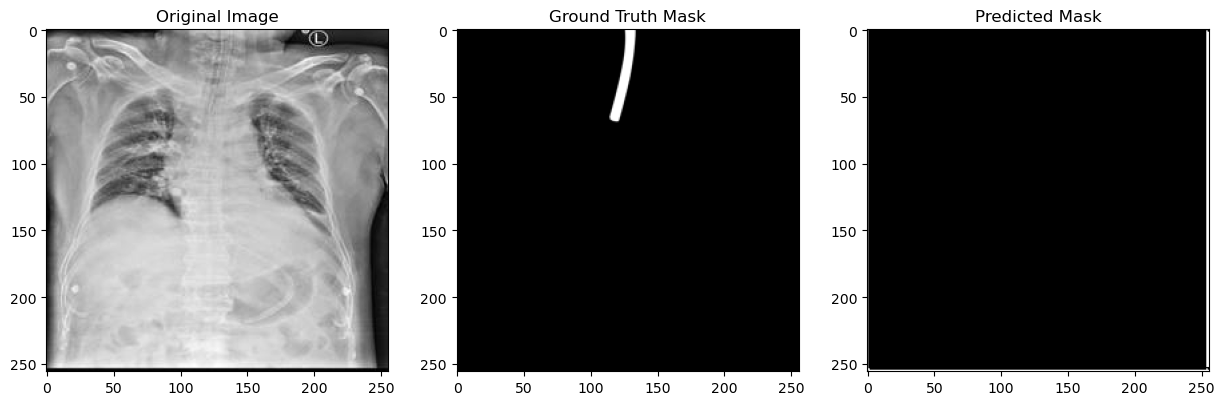

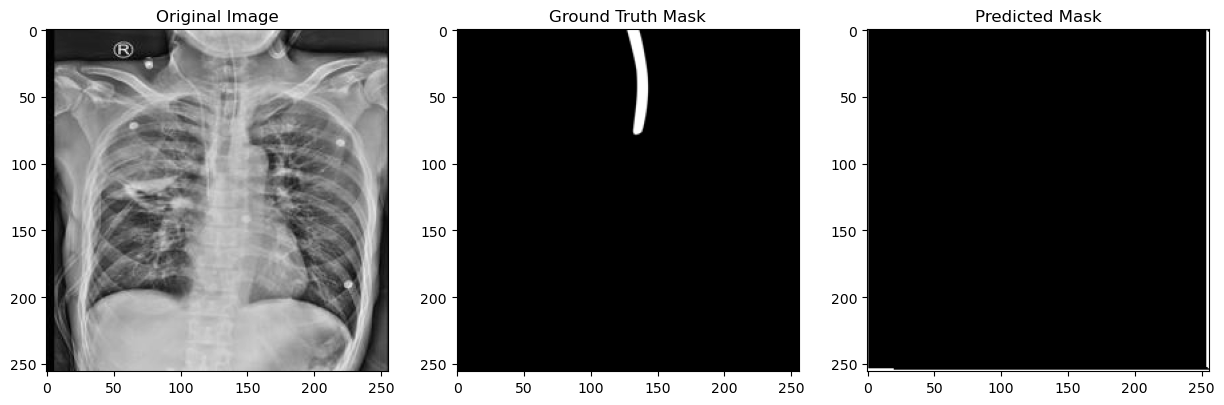

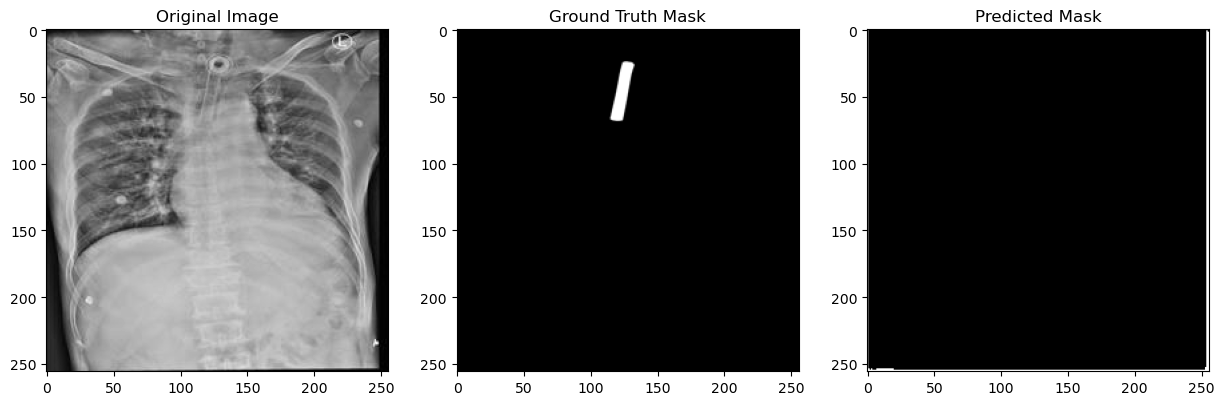

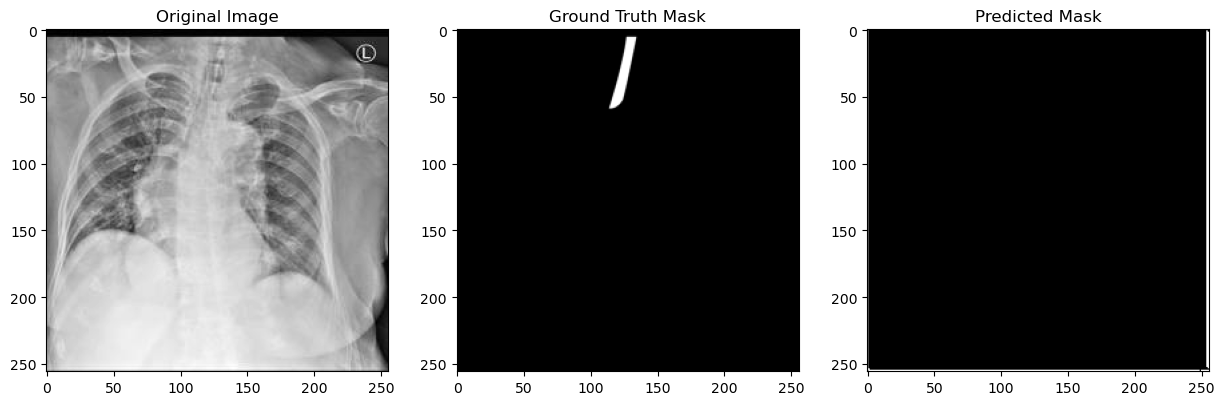

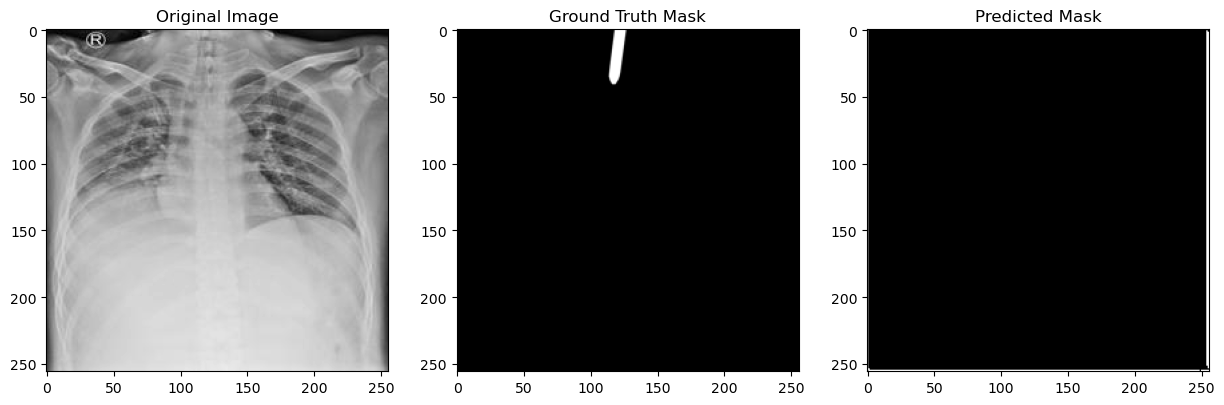

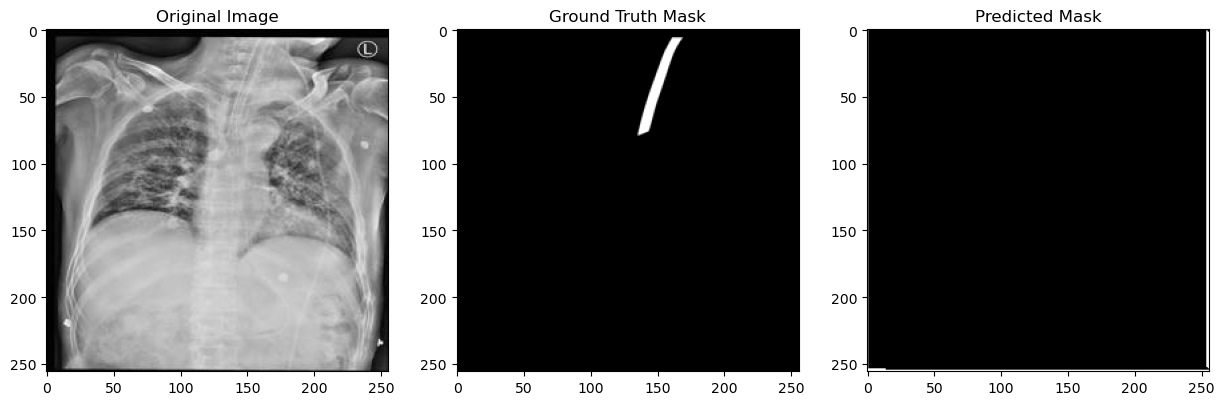

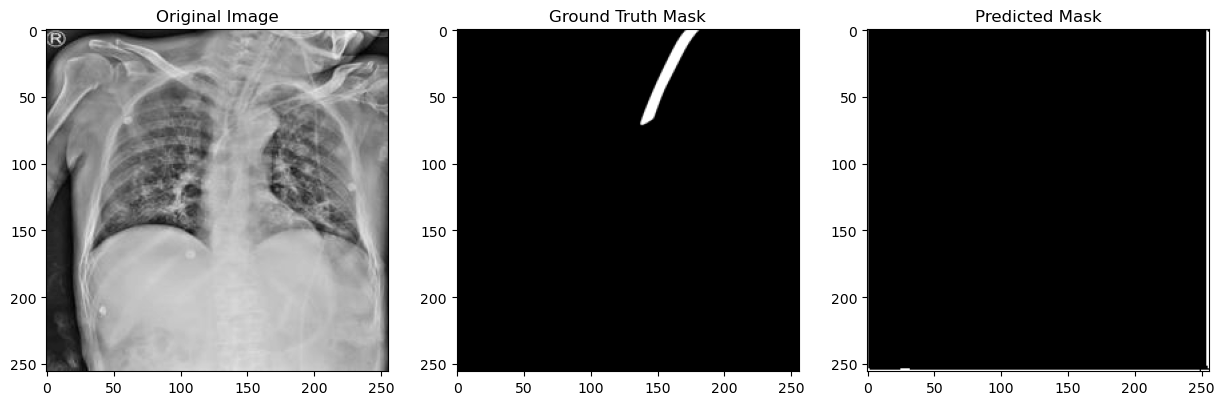

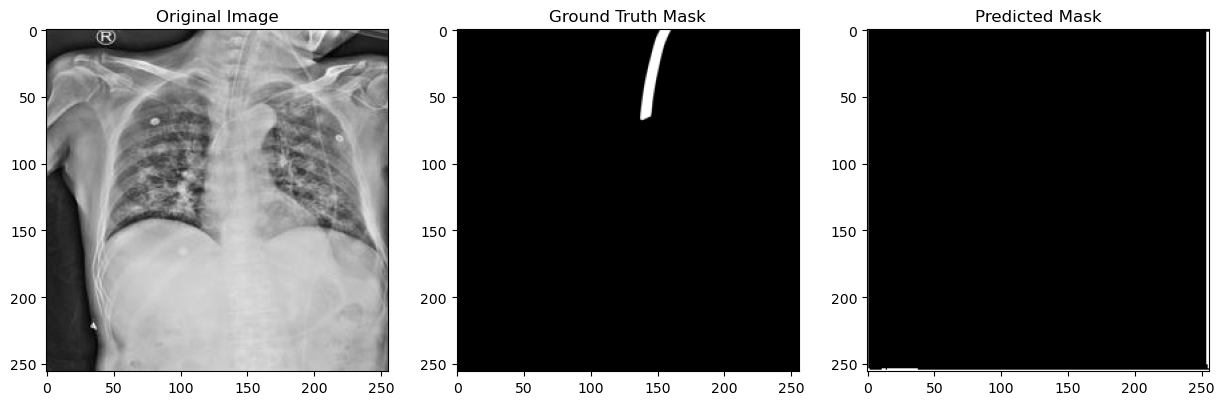

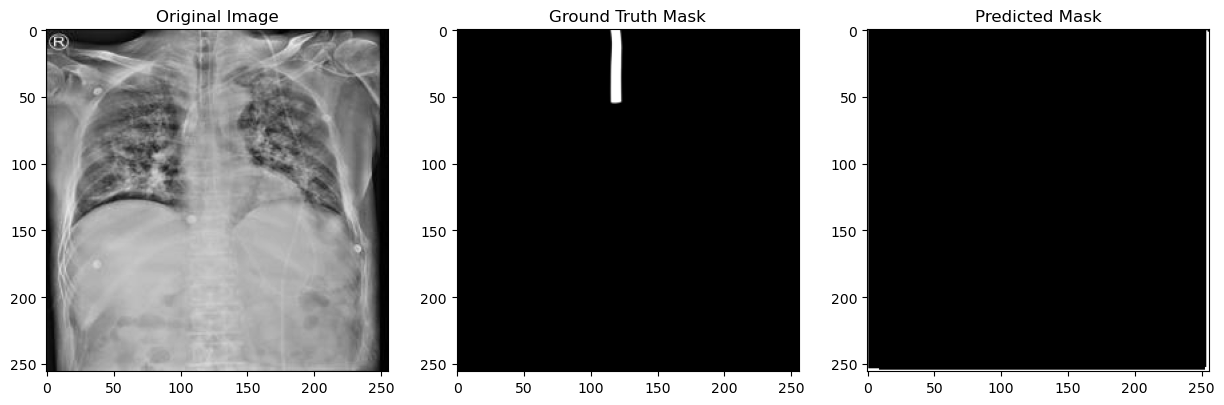

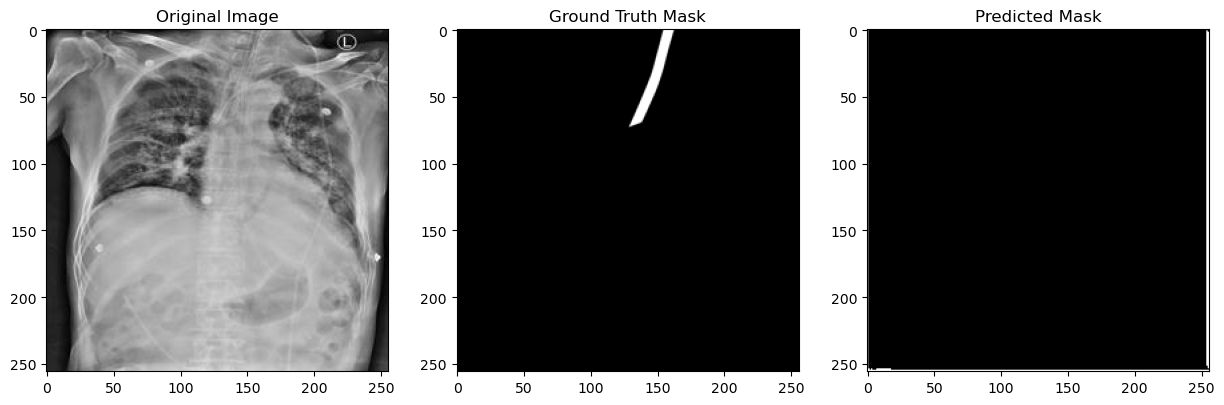

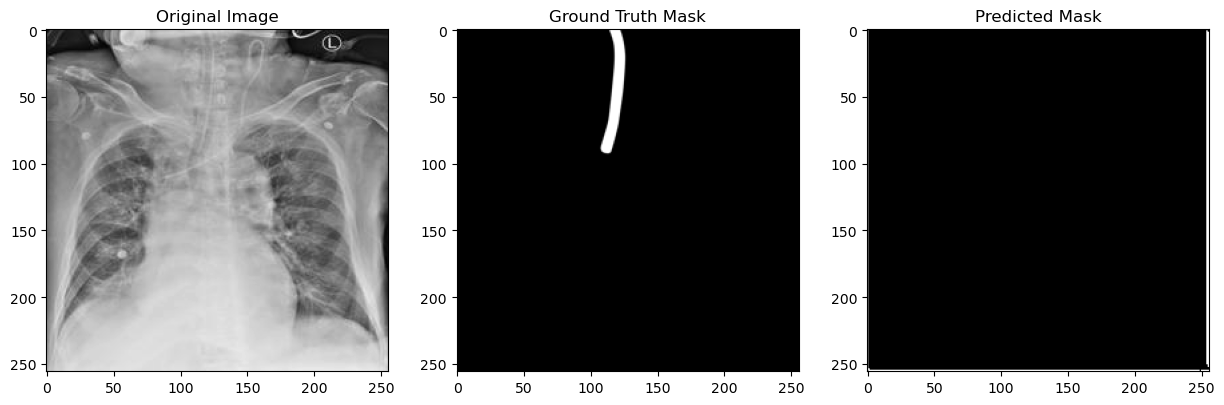

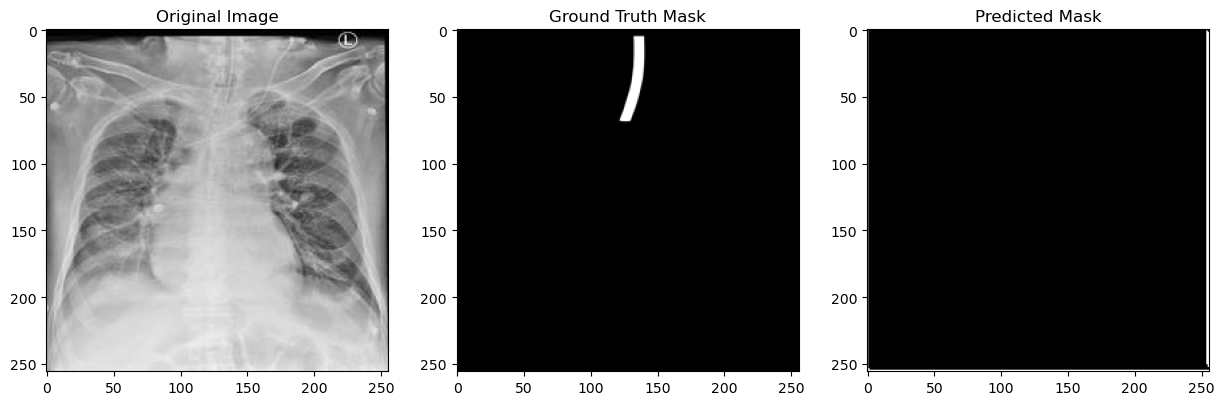

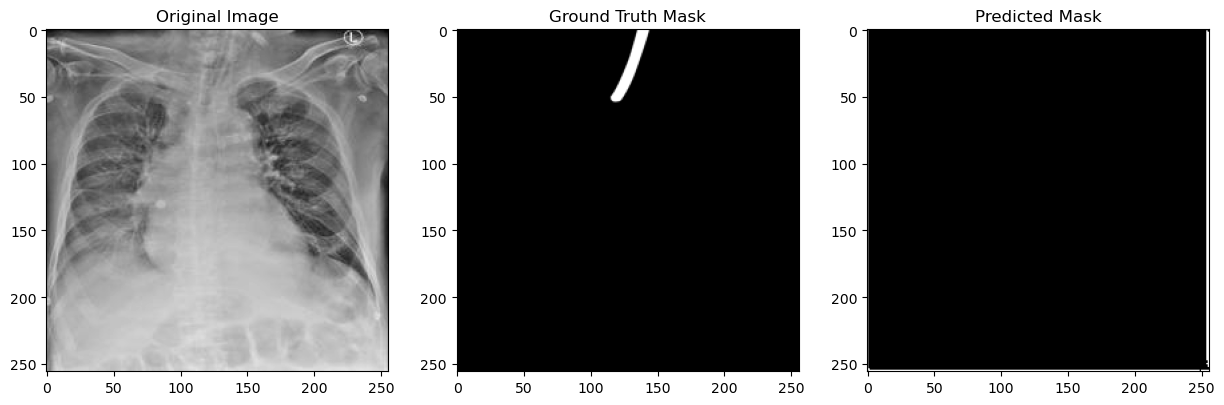

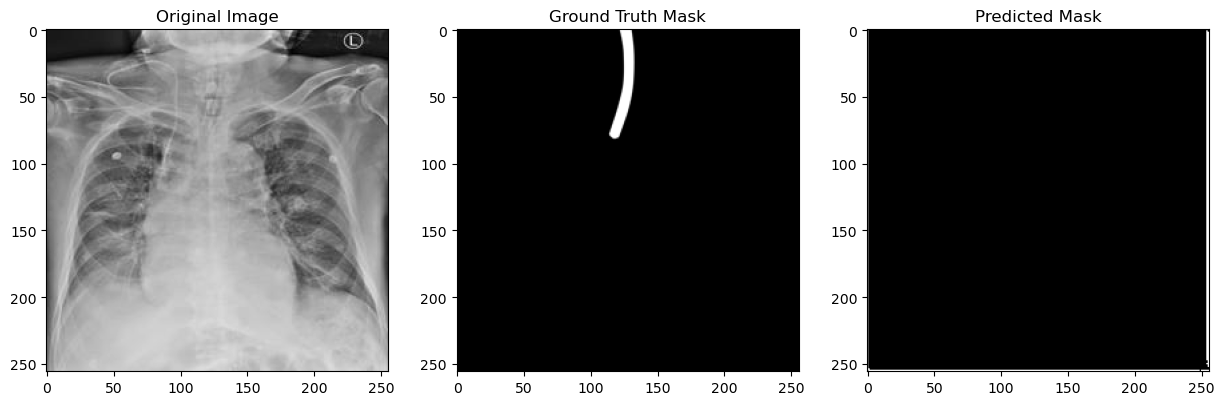

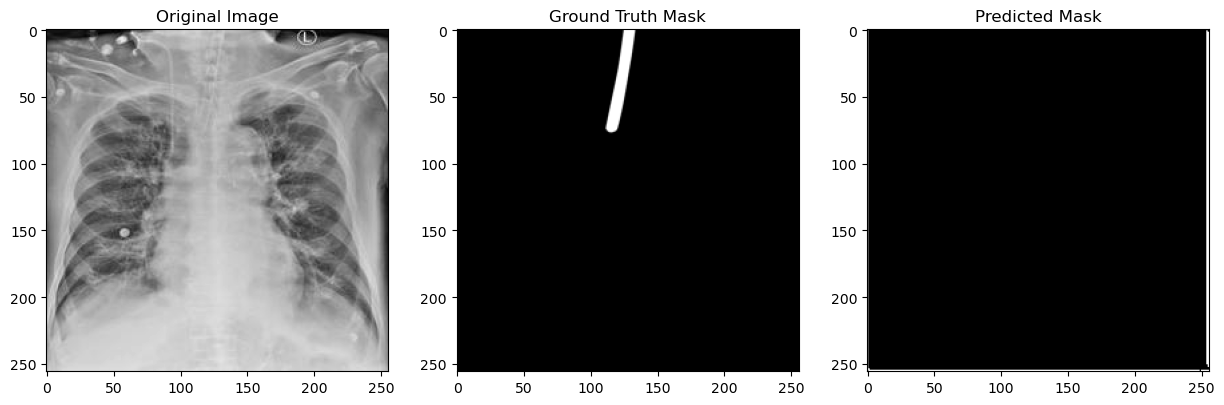

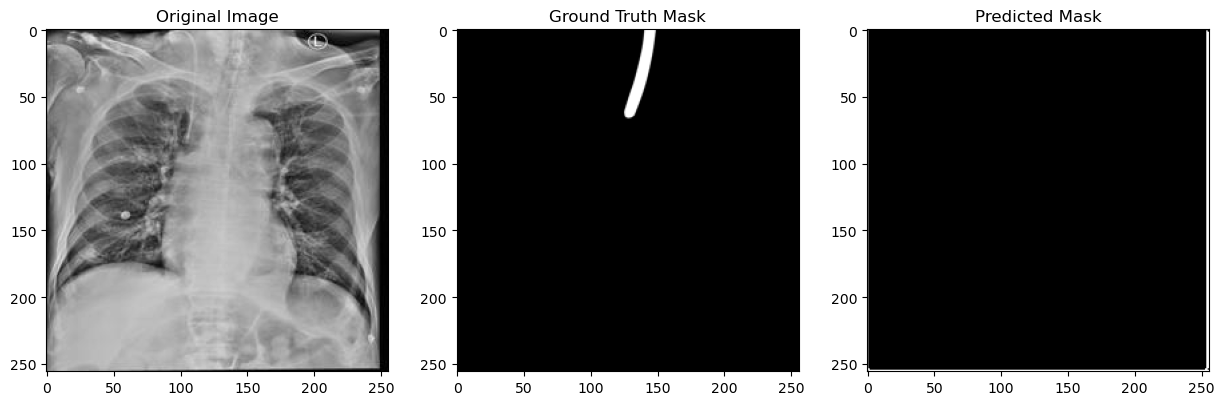

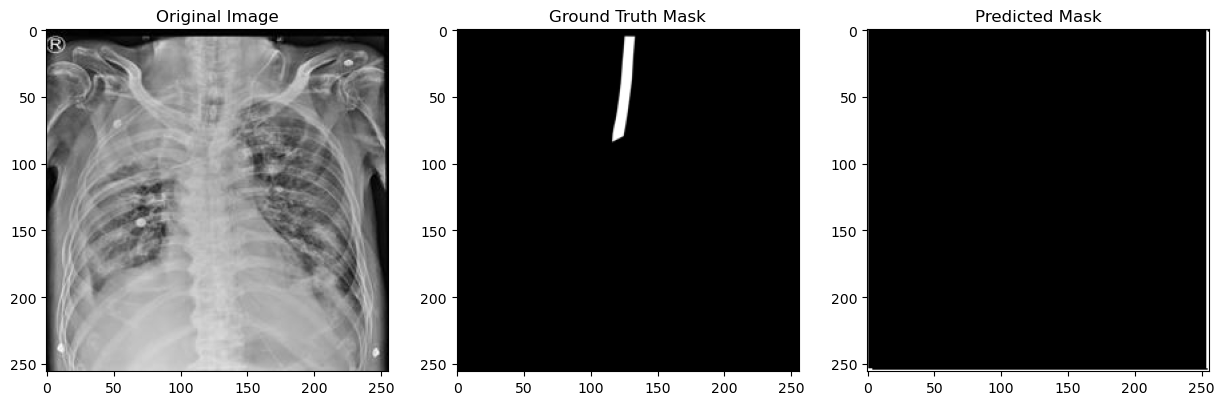

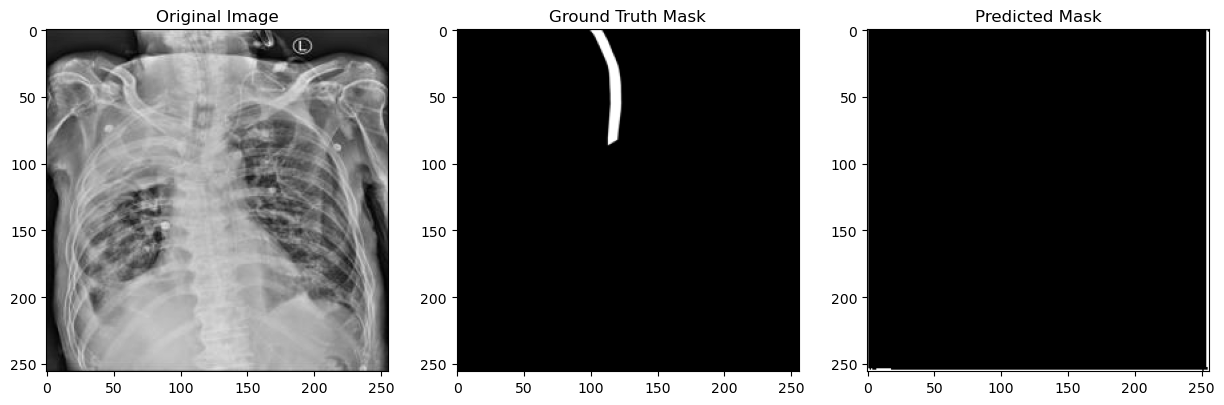

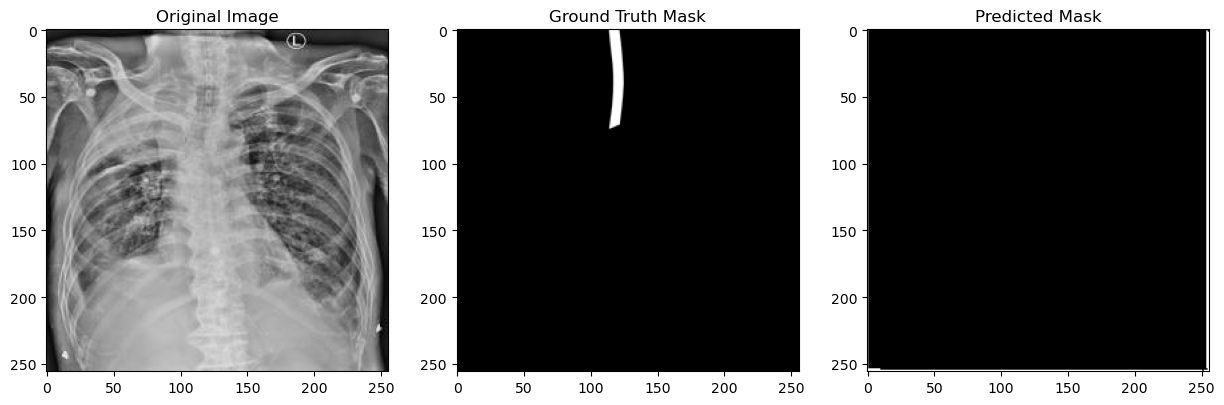

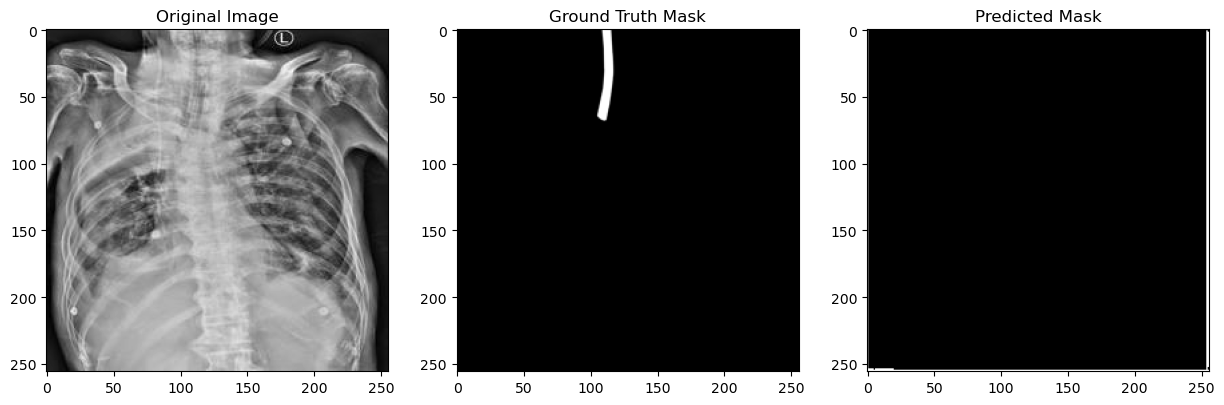

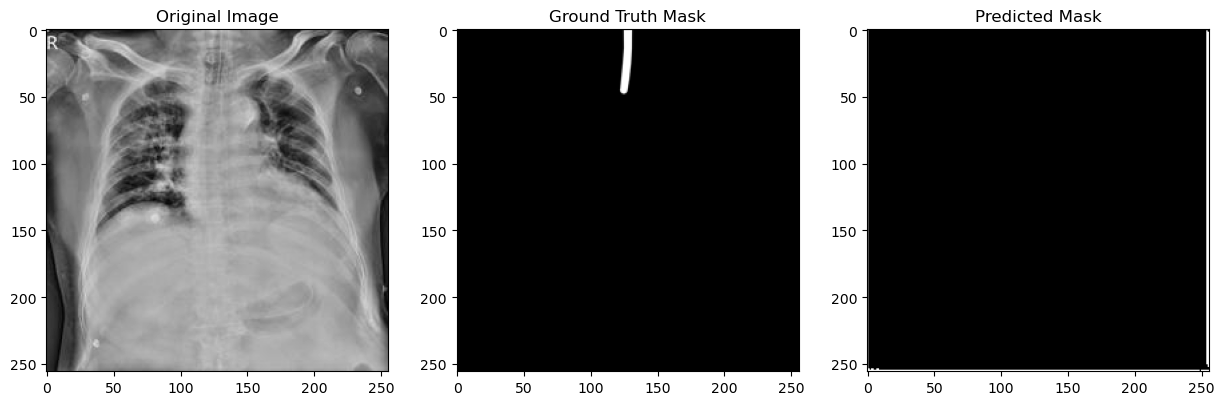

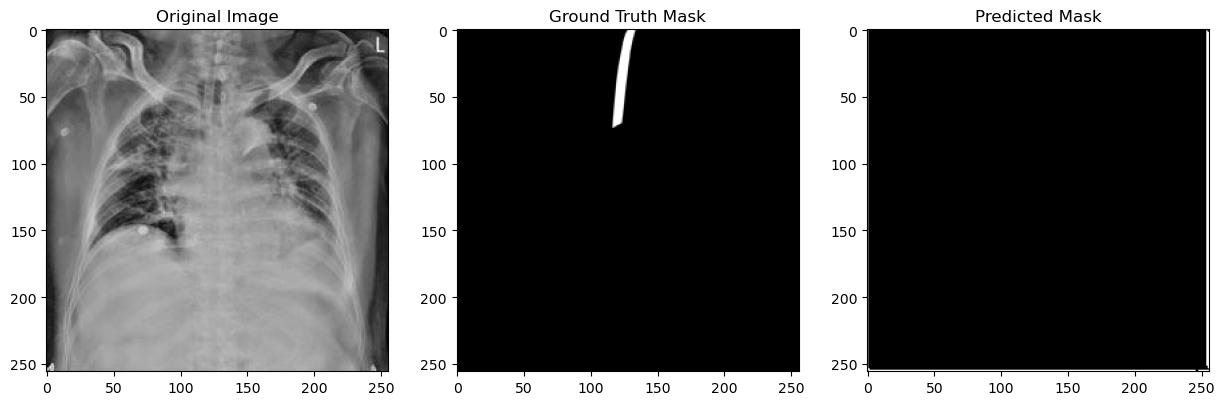

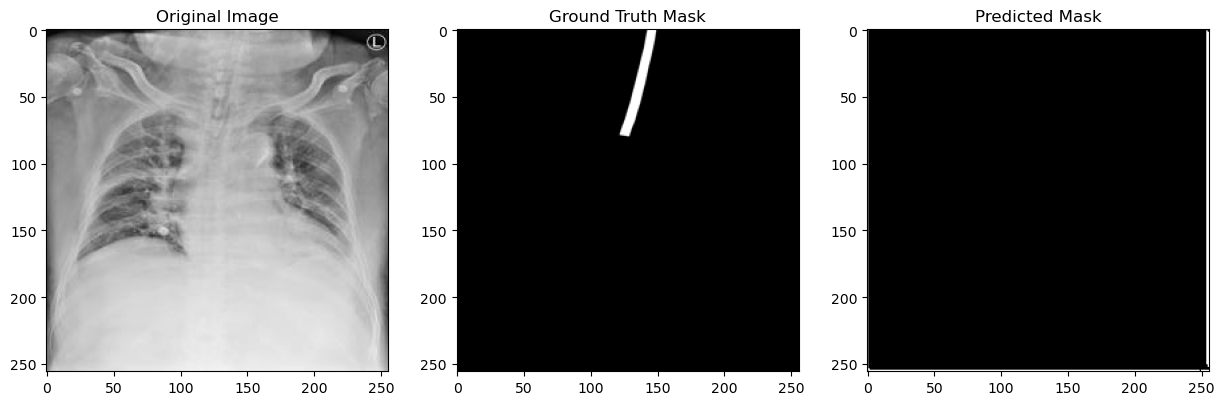

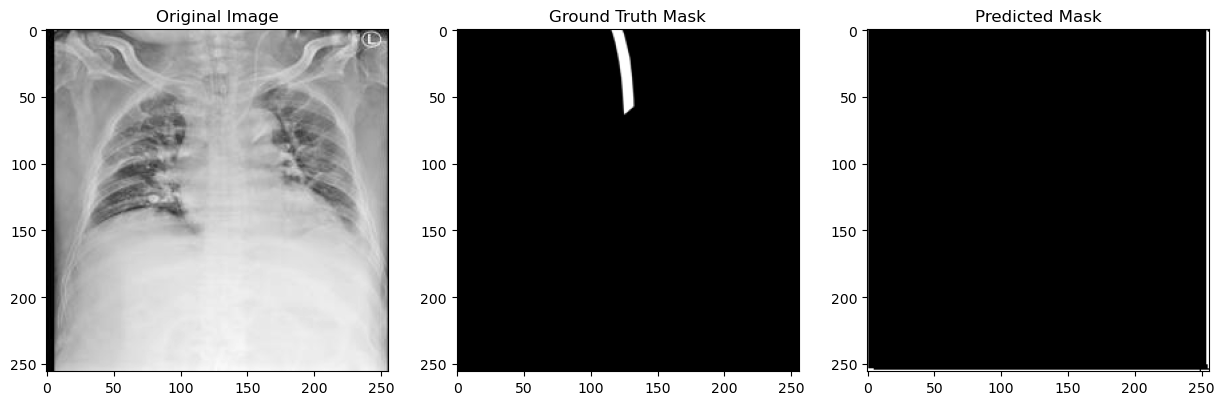

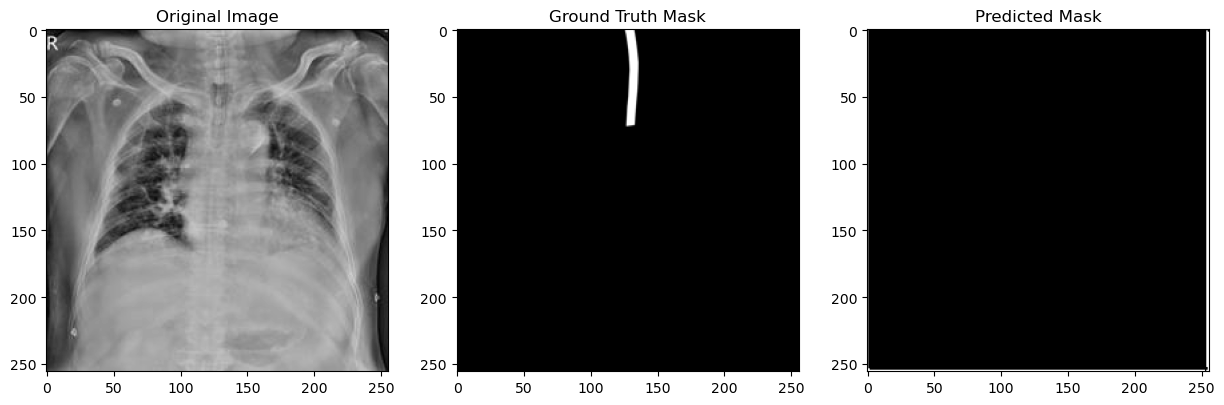

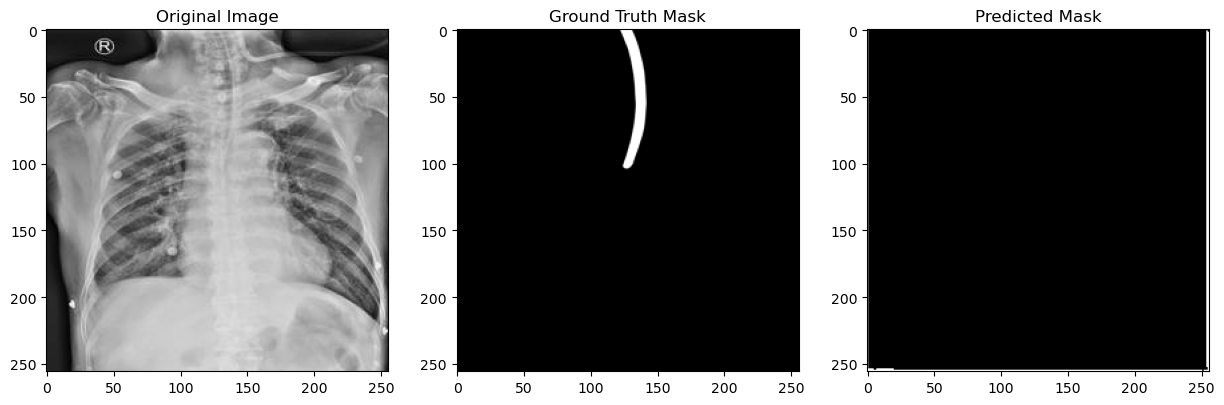

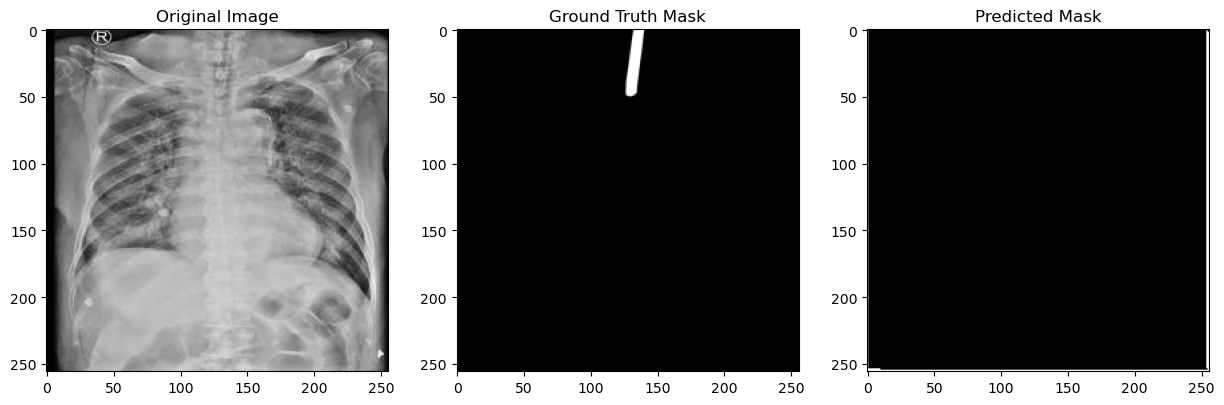

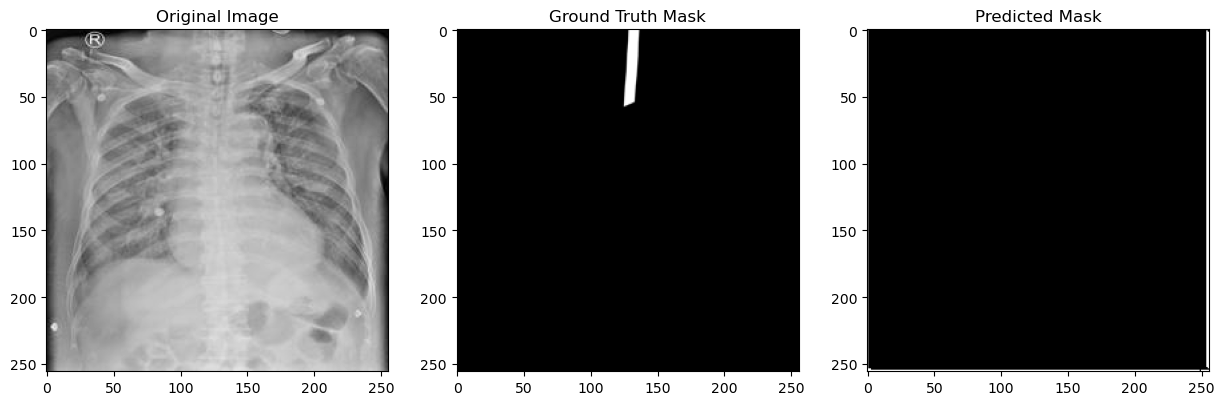

In [56]:
import matplotlib.pyplot as plt

# 顯示原圖、真實圖和預測圖
num_images = min(1, len(test_input_img_paths))  # 限制顯示的圖片數量，這裡設定為最多顯示1張圖片
for i in range(num_images):
    # 原圖
    original_img = Image.open(test_input_img_paths[i])
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")

    # 真實圖
    true_mask = Image.open(test_target_img_paths[i])
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # 預測圖
    pred_mask = predictions[i]
    pred_mask[pred_mask < 0.5] = 255  # 背景設置為白色
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()
